In [5]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import gamma
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.metrics import *
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer 
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier
)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib.gridspec import GridSpec

from features import get_feature_columns_for_healthscore
from data import (
    data_dir, project_dir, model_dir
)

from datetime import datetime
import warnings, os, shutil, joblib
warnings.filterwarnings(action='ignore') 

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(5,5)})
pd.set_option('display.max_columns', None)


In [6]:
## constants
np.random.seed(369)
rs = 369
cp_bins = 30

In [7]:
# plot hist
def plot_prob_dist(y_score, title):
    prob_dist = (1 - y_score) * 1000
    print(pd.DataFrame(prob_dist, columns = ['score']).describe())

    fig, ax = plt.subplots(figsize=(6,6))
    ax = sns.distplot(
        prob_dist, 
        kde=False,
        hist=True,
        bins=cp_bins,
        color='blue',
        # hist_kws={"linewidth": 15,'alpha':1}
        )
    ax.set(
        xlabel='(1-predict_proba)*1000', 
        ylabel='Frequency', 
        title = title, 
        # xlim = (0,1000)
        )
    plt.show()

In [8]:
score_types = ['M', 'F']
model = LogisticRegression(
                random_state=rs,
                n_jobs=-1,
                max_iter=2000,
                class_weight='balanced', 
                solver="sag",
        )
imputer = SimpleImputer(strategy='median')

In [9]:
og_df = pd.read_pickle(
    os.path.join(data_dir, 'processed', 'Healthscore_features.pkl'))

In [10]:
# check prevalence
df = og_df
alive, dead = df.Death_EVENT.value_counts()
print('alive: {}, dead: {}'.format(alive, dead))
death_rate = dead / (alive + dead)
print('Prevalence (death rate):', round(death_rate,4))

alive: 166951, dead: 5292
Prevalence (death rate): 0.0307


In [11]:
og_df.head()

,PERSON_ID,DTH_MDY,HME_DT,MACE_RECU_FR_DT,SEX,AGE,BMI,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,HCHK_APOP_PMH_YN,HCHK_HDISE_PMH_YN,HCHK_HPRTS_PMH_YN,HCHK_DIABML_PMH_YN,HCHK_HPLPDM_PMH_YN,HCHK_ETCDSE_PMH_YN,HCHK_PHSS_PMH_YN,FMLY_APOP_PATIEN_YN,FMLY_HDISE_PATIEN_YN,FMLY_HPRTS_PATIEN_YN,FMLY_DIABML_PATIEN_YN,FMLY_CANCER_PATIEN_YN,SMK_STAT_TYPE_RSPS_CD,PAST_DSQTY_RSPS_CD,CUR_DSQTY_RSPS_CD,DRNK_HABIT_RSPS_CD,TM1_DRKQTY_RSPS_CD,MOV20_WEK_FREQ_ID,MOV30_WEK_FREQ_ID,WLK30_WEK_FREQ_ID,METs,eGFR,Death_EVENT,MACE_EVENT,SMK_TERM_RSPS_CD
2,10001121,NaT,2009-04-29,NaT,1,86,21.500000,76.0,170.0,90.0,94.0,250.0,112.0,52.0,176.0,10.199219,1.0,12.599609,35.0,15.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,20,0,1,0,1,1,2,434.0,3.398443,0,0,30
5,10001153,2012-04-02,2011-06-02,NaT,1,88,21.078125,70.0,130.0,80.0,75.0,211.0,129.0,35.0,150.0,12.699219,1.0,0.899902,16.0,11.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,1,1,1,347.0,81.573635,1,0,0
8,10003515,NaT,2009-12-07,NaT,0,86,18.667969,71.0,140.0,90.0,86.0,211.0,72.0,66.0,130.0,11.500000,1.0,1.099854,27.0,11.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,1,3,1,587.0,48.845610,0,0,0
9,10003910,2012-03-02,2009-03-11,NaT,1,86,27.339844,84.0,184.0,65.0,105.0,235.0,122.0,65.0,145.0,12.798828,1.0,1.000000,23.0,21.0,24.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,1,1,1,347.0,72.712931,1,0,0
19,10006622,NaT,2009-02-23,NaT,0,86,20.449219,68.0,130.0,70.0,84.0,196.0,62.0,63.0,120.0,12.798828,1.0,0.699951,18.0,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,0,3,1,3,801.0,84.350140,0,0,0


In [12]:
og_df.columns

Index(['PERSON_ID', 'DTH_MDY', 'HME_DT', 'MACE_RECU_FR_DT', 'SEX', 'AGE',
       'BMI', 'WAIST', 'BP_HIGH', 'BP_LWST', 'BLDS', 'TOT_CHOLE',
       'TRIGLYCERIDE', 'HDL_CHOLE', 'LDL_CHOLE', 'HMG', 'OLIG_PROTE_CD',
       'CREATININE', 'SGOT_AST', 'SGPT_ALT', 'GAMMA_GTP', 'HCHK_APOP_PMH_YN',
       'HCHK_HDISE_PMH_YN', 'HCHK_HPRTS_PMH_YN', 'HCHK_DIABML_PMH_YN',
       'HCHK_HPLPDM_PMH_YN', 'HCHK_ETCDSE_PMH_YN', 'HCHK_PHSS_PMH_YN',
       'FMLY_APOP_PATIEN_YN', 'FMLY_HDISE_PATIEN_YN', 'FMLY_HPRTS_PATIEN_YN',
       'FMLY_DIABML_PATIEN_YN', 'FMLY_CANCER_PATIEN_YN',
       'SMK_STAT_TYPE_RSPS_CD', 'PAST_DSQTY_RSPS_CD', 'CUR_DSQTY_RSPS_CD',
       'DRNK_HABIT_RSPS_CD', 'TM1_DRKQTY_RSPS_CD', 'MOV20_WEK_FREQ_ID',
       'MOV30_WEK_FREQ_ID', 'WLK30_WEK_FREQ_ID', 'METs', 'eGFR', 'Death_EVENT',
       'MACE_EVENT', 'SMK_TERM_RSPS_CD'],
      dtype='object')

In [13]:
og_df.eGFR.describe()

count    172243.000000
mean         84.796510
std          21.117413
min           0.369327
25%          74.343361
50%          87.587855
75%         100.395447
max         259.705872
Name: eGFR, dtype: float64

<AxesSubplot: >

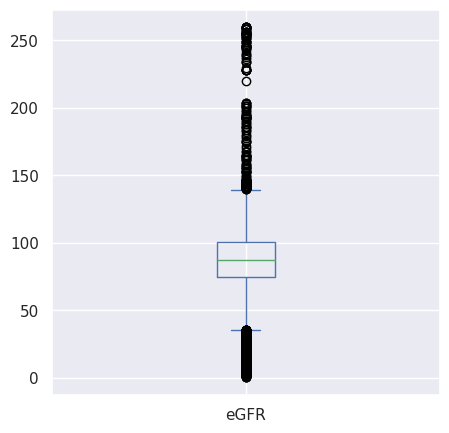

In [14]:
og_df.eGFR.plot(kind='box')

In [15]:
# chose model type
target_column = 'Death_EVENT' # mortality
# target_column = 'cancer_EVENT' # cancer positive
# target_column = 'MACE_EVENT' # MACE

# choose gendered or not
gendered = 'uni'


In [16]:
if gendered == 'bi':
    feat_set = 'w/ 2squared'
    # for each sex
    coef_dfs = []
    for score_type in score_types:
        df1 = og_df
        init_cnt = df.shape[0]
        print('init row cnt:', init_cnt)

        if score_type=='M':
            df = df1[df1['SEX']==1]
            np.random.seed(2020)
            pids = df['PERSON_ID'].unique()
            test_pids_man = np.random.choice(pids, size=int(len(pids) * 0.2))
            test_mask_man = np.in1d(df['PERSON_ID'], test_pids_man)
            test_pids = test_pids_man
            test_mask = test_mask_man
        elif score_type=='F':
            df = df1[df1['SEX']==0]
            np.random.seed(2020)
            pids = df['PERSON_ID'].unique()
            test_pids_woman = np.random.choice(pids, size=int(len(pids) * 0.2))
            test_mask_woman = np.in1d(df['PERSON_ID'], test_pids_woman)
            test_pids = test_pids_woman
            test_mask = test_mask_woman

        screen_features, family_past_features, habitual_features = \
            get_feature_columns_for_healthscore()
        feature_columns = screen_features+family_past_features+habitual_features

        multi_col = ['METs', 'TM1_DRKQTY_RSPS_CD']
        for col in multi_col:
            df[col+'^2'] = df[col]**2

        print('---Training healthscore model for {}'.format(score_type))

        selected_features = screen_features+family_past_features+habitual_features+ \
            ['METs^2', 'TM1_DRKQTY_RSPS_CD^2']

        # standardize
        data = df
        std = data.loc[~test_mask, selected_features].std()
        mean = data.loc[~test_mask, selected_features].mean()
        data[selected_features] = (data[selected_features]-mean)/std

        # model
        train_df, test_df = data[~test_mask], data[test_mask]

        model.fit(train_df[selected_features], train_df[target_column])

        y_score = model.predict_proba(test_df[selected_features])[:, 1]
        y_pred = np.array(y_score > 0.5, dtype=np.int32)
        y_test = np.array(test_df[target_column], dtype=np.int32)

        roc_auc_ = roc_auc_score(y_test, y_score)
        apr_ = average_precision_score(y_test, y_score)
        print('AUROC score for {}: {}'. format(feat_set, round(roc_auc_, 4)))
        print('AUPRC score for {}: {}'. format(feat_set, round(apr_, 4)))
        print()

        # score plots
        title='Score Distribution (Sex={}, {}, Cnt={})'.format(
            score_type, feat_set, init_cnt)
        plot_prob_dist(y_score, title)
        print()

        # coefs
        feature_desc = [['_intercept', model.intercept_[0]-(model.coef_[0]*mean/std).sum()]]
        for i, c in enumerate(selected_features):
            feature_desc.append([c, (model.coef_[0]/std)[i]])

        coef_dfs_ = pd.DataFrame(feature_desc)
        coef_dfs_.columns = ['{} features'.format(score_type), 'feature coefficient']
        coef_dfs.append(coef_dfs_)
        fpath = os.path.join(project_dir, 'reports', 'Healthscore_uncalib_log_reg_{}.csv'.format(feat_set))
        pd.concat(coef_dfs, axis=1).to_csv(fpath, index=False)

In [22]:
if gendered == 'uni':
    # for all sex
    df = og_df
    coef_dfs = []
    score_type = 'combined'
    feat_set = 'with 2squared feats'

    init_cnt = df.shape[0]
    print('init row cnt:', init_cnt)

    np.random.seed(2020)
    pids = df['PERSON_ID'].unique()
    test_pids= np.random.choice(pids, size=int(len(pids) * 0.2))
    test_mask= np.in1d(df['PERSON_ID'], test_pids)

    screen_features, family_past_features, habitual_features = \
        get_feature_columns_for_healthscore()
    feature_columns = screen_features+family_past_features+habitual_features

    multi_col = ['METs', 'TM1_DRKQTY_RSPS_CD']
    for col in multi_col:
        df[col+'^2'] = df[col]**2

    print('---Training healthscore model for {}'.format(score_type))

    selected_features = screen_features+family_past_features+habitual_features+ \
        ['METs^2', 'TM1_DRKQTY_RSPS_CD^2']
    selected_features = [it for it in selected_features if it not in ['AGE', 'WAIST', 'eGFR']]
    
    # standardize
    data = df
    std = data.loc[~test_mask, selected_features].std()
    mean = data.loc[~test_mask, selected_features].mean()
    data[selected_features] = (data[selected_features]-mean)/std

    # model
    train_df, test_df = data[~test_mask], data[test_mask]

    model.fit(train_df[selected_features], train_df[target_column])

    y_score = model.predict_proba(test_df[selected_features])[:, 1]
    y_pred = np.array(y_score > 0.5, dtype=np.int32)
    y_test = np.array(test_df[target_column], dtype=np.int32)

    roc_auc_ = roc_auc_score(y_test, y_score)
    apr_ = average_precision_score(y_test, y_score)
    print('AUROC score for {}: {}'. format(feat_set, round(roc_auc_, 4)))
    print('AUPRC score for {}: {}'. format(feat_set, round(apr_, 4)))
    print()

    # # score plots
    # title='Score Distribution (Sex={}, {}, Cnt={})'.format(
    #     score_type, feat_set, init_cnt)
    # plot_prob_dist(y_score, title)
    # print()

    # coefs
    feature_desc = [['_intercept', model.intercept_[0]]]
    for i, c in enumerate(selected_features):
        feature_desc.append([c, model.coef_[0][i]])

    coef_dfs_ = pd.DataFrame(feature_desc)
    coef_dfs_.columns = ['{} features'.format(score_type), 'feature coefficient']
    coef_dfs.append(coef_dfs_)
    fpath = os.path.join(project_dir, 'reports', 'Healthscore_LEE_log_reg_{}.csv'.format(feat_set))
    pd.concat(coef_dfs, axis=1).to_csv(fpath, index=False)

init row cnt: 172243
---Training healthscore model for combined
AUROC score for with 2squared feats: 0.7771
AUPRC score for with 2squared feats: 0.1459

